<a href="https://colab.research.google.com/github/eshaan90/IOT-Analytics/blob/master/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
import math


In [0]:

def plot_qqplot(residuals,var,title):
    '''
        Function to plot Q-Q plots.
    '''
    plt.figure()
    sm.qqplot(residuals,loc=0,scale=var**0.5,line='q')
    plt.tight_layout()
    plt.title(title)
    plt.show()

In [0]:

def plot_scatterplot_residuals(predictions,residuals,xlabel,ylabel,title):
    '''
        Function to plot a scatter plot for the residuals.
    '''
    plt.figure()
    plt.scatter(predictions,residuals)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [0]:

def plot_observed_vs_forecasted_time_series(observed, forecasted, xlabel, ylabel, title, filename):
    fig=plt.figure()
    plt.plot(observed, label='Original Values')
    plt.plot(forecasted, label='Predicted Values')
    plt.legend(loc='best')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.title(title)
    fig.savefig(filename)
    plt.show()

In [0]:
def chi_squared_test(x):
    k2, p = stats.normaltest(x)
    alpha = 0.05
    print("\n\np = {:g}".format(p))
    
    if p > alpha:  # null hypothesis: x comes from a normal distribution
        print("Not Significant Result; We fail to reject the null hypothesis")
    else:
        print("Significant Result; The null hypothesis can be rejected")  

In [0]:
def computing_var(X):
    return np.var(X)

In [0]:
def compute_residuals(pred,original):
    return original-pred

In [0]:
def compute_rmse(errors):
    rmse=math.sqrt(np.sum(np.multiply(errors,errors))/len(errors))
    return rmse

In [0]:
def augmented_dickey_fuller_test(ts):
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
    	print('\t%s: %.3f' % (key, value))

In [0]:
def simple_moving_average(dataset, k):
    '''
        This function computes the simple moving average over the input dataset with a window
        size of 'k'. It outputs the simple moving average forecasts over the dataset.
    '''
    mwa=[]
    for i in range(len(dataset)):
        if i<k:
            mwa.append(0)
        else:
            mwa.append(np.mean(dataset[i-k:i]))
    return mwa


# Load and understand the data

In [0]:
#Load the dataset
dataset=pd.read_csv('evkirpal.csv',header=None,names=['Y'])
ts=dataset.Y

In [68]:
dataset.head(10)

,Y
0,13.283
1,13.808
2,13.679
3,13.527
4,14.304
5,14.427
6,14.966
7,14.546
8,13.944
9,13.904


In [69]:
dataset.describe()

,Y
count,2000.000000
mean,14.372821
std,1.051624
min,10.431000
25%,13.652000
50%,14.375500
75%,15.103000
max,18.005000


Text(0.5, 1.0, 'Visualizing the dataset')

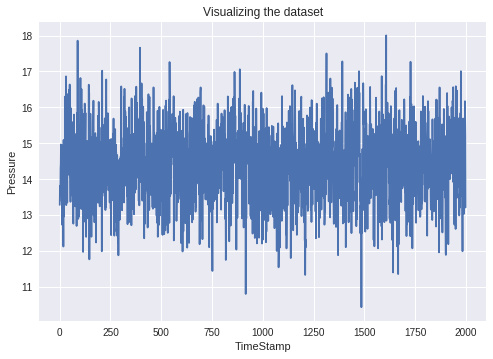

In [97]:
plt.figure()
plt.plot(ts)
plt.xlabel('TimeStamp')
plt.ylabel('Pressure')
plt.title('Visualizing the dataset')

**Check for Stationarity**

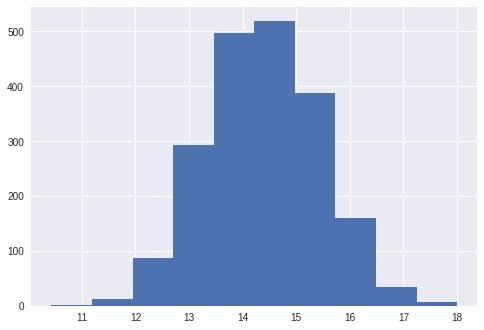

In [70]:
plt.figure()
ts.hist(label='Histogram of Dataset')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


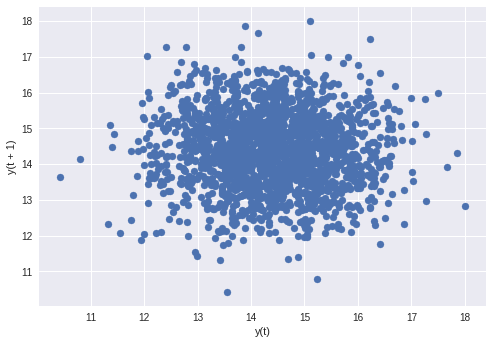

In [71]:
#Lag plots are used to check if a data set or time series is random. 
#Random data should not exhibit any structure in the lag plot. 
#Non-random structure implies that the underlying data are not random.
plt.figure()
lag_plot(ts) 

In [0]:
# Split the dataset into train and test
sep_index=1500
train=ts[:sep_index]
test=ts[sep_index:]

**Simple Moving Average**


 RMSE for window size k=10 is: 1.0844620472100102


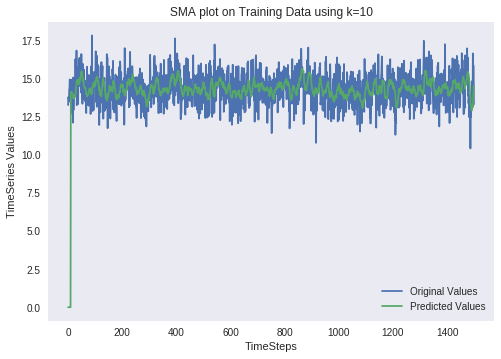

In [73]:
#We first make predictions on the training data with a window size of 10.
k=10
mwa=simple_moving_average(train, k)           
sma_residuals=compute_residuals(mwa[k:], train[k:])
print('\n RMSE for window size k={} is: {}'.format(k, compute_rmse(sma_residuals)))

plot_observed_vs_forecasted_time_series(train, mwa, 
                                        'TimeSteps', 'TimeSeries Values',
                                        'SMA plot on Training Data using k={}'.format(k),
                                        'SMA_K_10')


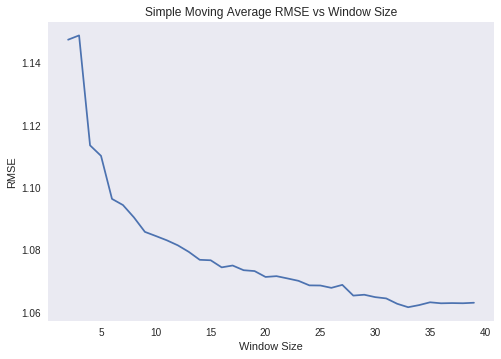

In [74]:
# Next we find the optimum window size by iterating over window sizes from 0 to 40. 
#We can take a larger window size as well.
max_window_size=40
sma_rmse=[]
window_size=list(range(2,max_window_size,1))
for k in window_size:
    mwa=simple_moving_average(train, k)
    sma_residuals=compute_residuals(mwa[k:],train[k:])
    sma_rmse.append(compute_rmse(sma_residuals))

fig4=plt.figure()
plt.plot(window_size, sma_rmse)
plt.grid()
plt.xlabel('Window Size')
plt.ylabel('RMSE')
plt.title('Simple Moving Average RMSE vs Window Size')
fig4.savefig('Simple Moving Average')

In [75]:
index=sma_rmse.index(min(sma_rmse))
optimum_window=window_size[index]
mwa=simple_moving_average(train, optimum_window)
sma_residuals=compute_residuals(mwa[optimum_window:], train[optimum_window:])
print('\n RMSE for window size k={} is: {}'.format(optimum_window,compute_rmse(sma_residuals)))


 RMSE for window size k=33 is: 1.0616263186024815


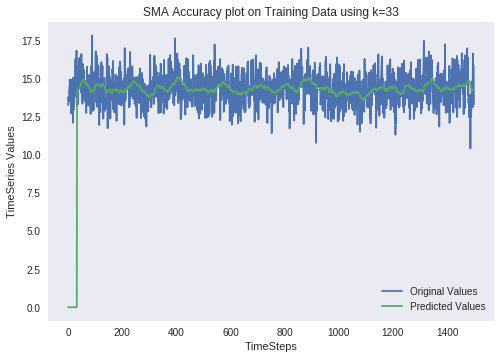

In [76]:
plot_observed_vs_forecasted_time_series(train, mwa, 
                                        'TimeSteps', 'TimeSeries Values',
                                        'SMA Accuracy plot on Training Data using k={}'.format(optimum_window),
                                        'SMA_train_K_{}'.format(optimum_window))

**EXPONENTIAL SMOOTHING MODEL**

In [0]:
alpha=0.1
s=0
ews=[s]
for i in range(1,len(train)):
    s=alpha*train[i-1]+(1-alpha)*s
    ews.append(s)

In [78]:
ews_residuals=compute_residuals(ews, train)
print('\n RMSE for window size alpha={} is: {}'.format(alpha,compute_rmse(ews_residuals)))


 RMSE for window size alpha=0.1 is: 1.3408732517933069


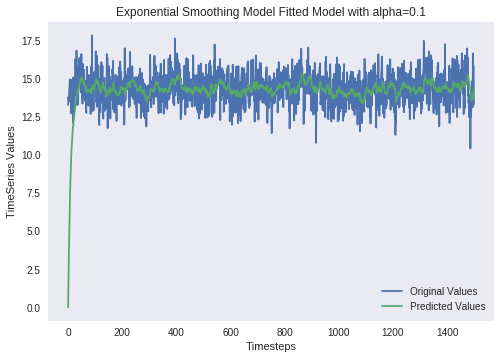

In [79]:
fig5=plt.figure()
plt.plot(train, label='Original Values')
plt.plot(ews, label='Predicted Values')
plt.legend(loc='best')
plt.xlabel('Timesteps')
plt.ylabel('TimeSeries Values')
plt.grid()
plt.title('Exponential Smoothing Model Fitted Model with alpha={}'.format(alpha))
#fig5.savefig('ESM- Accuracy plot for Training Data')
plt.show()

In [0]:
alpha=list(range(1,10,1))
alpha=[x/10 for x in alpha]

ews_rmse=[]
for a in alpha:
    s=0
    ews=[s]
    for i in range(1,len(train)):
        s=a*train[i-1]+(1-a)*s
        ews.append(s)
    ews_residuals=compute_residuals(ews, train)
    ews_rmse.append(compute_rmse(ews_residuals))

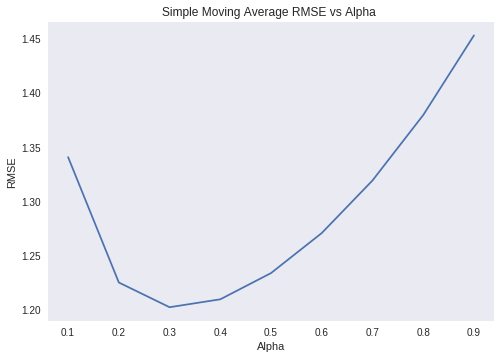

In [81]:
fig7=plt.figure()
plt.plot(alpha, ews_rmse)
plt.grid()
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Simple Moving Average RMSE vs Alpha ')
#fig7.savefig('Exponential Smoothing Model')
plt.show()

In [82]:
index=ews_rmse.index(min(ews_rmse))
optimum_alpha=alpha[index]

s=0
ews=[s]
for i in range(1,len(train)):
    s=optimum_alpha*train[i-1]+(1-optimum_alpha)*s
    ews.append(s)

ews_residuals=compute_residuals(ews, train)
print('\n RMSE for window size alpha={} is: {}'.format(optimum_alpha,compute_rmse(ews_residuals)))


 RMSE for window size alpha=0.3 is: 1.2024969901671971


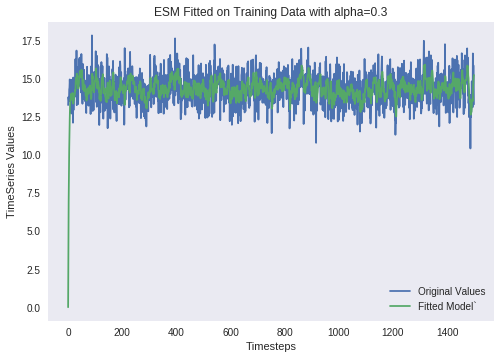

In [83]:
fig15=plt.figure()
plt.plot(train, label='Original Values')
plt.plot(ews, label='Fitted Model`')
plt.legend(loc='best')
plt.xlabel('Timesteps')
plt.ylabel('TimeSeries Values')
plt.grid()
plt.title('ESM Fitted on Training Data with alpha={}'.format(optimum_alpha))
#fig15.savefig('ESM- Accuracy plot for Training Data')
plt.show()

In [84]:
#Testing dataset using our model
s=0
ews=[s]
index=list(range(test.index[0],test.index[-1]+1))
for i in range(test.index[1],test.index[-1]+1):
    s=optimum_alpha*test[i-1]+(1-optimum_alpha)*s
    ews.append(s)
    
ews_pd=pd.Series(index=index,data=ews)
ews_residuals=compute_residuals(ews, test)
print('\n RMSE for window size k={} is: {}'.format(optimum_alpha,compute_rmse(ews_residuals)))


 RMSE for window size k=0.3 is: 1.4357558259581094


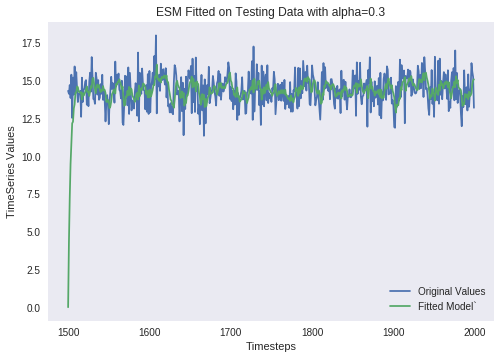

In [85]:
fig14=plt.figure()
plt.plot(test, label='Original Values')
plt.plot(ews_pd, label='Fitted Model`')
plt.legend(loc='best')
plt.xlabel('Timesteps')
plt.ylabel('TimeSeries Values')
plt.grid()
plt.title('ESM Fitted on Testing Data with alpha={}'.format(optimum_alpha))
#fig14.savefig('ESM- Accuracy plot for Testing Data')
plt.show()

**AutoRegression Model**

p value using PACF is 1


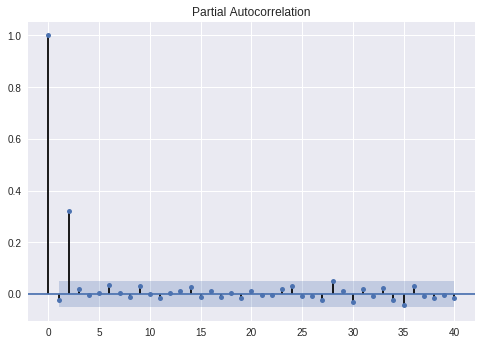

In [86]:
plot_pacf(train,lags=40, title='Partial Autocorrelation')

delta = 0.15
lag_pacf = pacf(train, nlags=40, method='yw')
upperInt = 1.96/np.sqrt(len(ts))
intPoint = -1

for i in range(0,len(lag_pacf)):
    if abs(lag_pacf[i]-upperInt) <= delta:
        print("p value using PACF is " + str(i))
        p = i
        break

In [0]:
train=train.as_matrix()

In [88]:
model = ARIMA(train, order=(p, 0, 0)) 
results_AR = model.fit()
residuals=compute_residuals(results_AR.fittedvalues, train)
rmse=compute_rmse(residuals)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Parameters of Autoregressive Model AR(%d) are: 
 [14.3629887 -0.0237808]


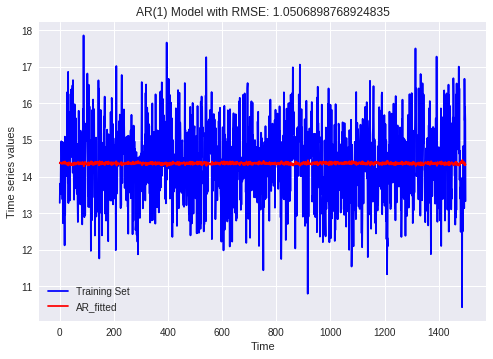

RMSE on Training Data: is 1.0506898768924835


In [89]:
print("Parameters of Autoregressive Model AR(%d) are: \n", results_AR.params) 
plt.figure()
plt.plot(train, color='blue', label='Training Set')
plt.plot(results_AR.fittedvalues, color='red', label="AR_fitted")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Time series values")
plt.title('AR({}) Model with RMSE: {}'.format(p, rmse))
plt.show()
print("RMSE on Training Data: is {}".format(rmse))

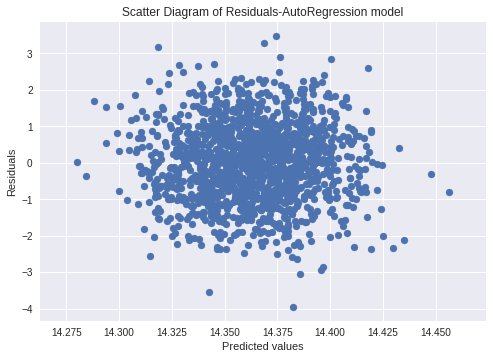

In [90]:
plot_scatterplot_residuals(results_AR.fittedvalues, residuals, 'Predicted values', 'Residuals',\
                               'Scatter Diagram of Residuals-AutoRegression model')



p = 0.777017
Not Significant Result; We fail to reject the null hypothesis
Variance of the Residuals= 1.1039492171114382


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


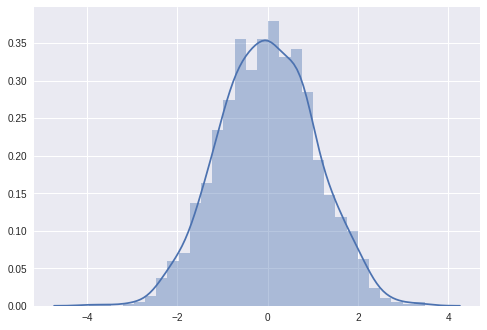

In [91]:
chi_squared_test(residuals)
var=computing_var(residuals)
print('Variance of the Residuals= {}'.format(var))
sns.distplot(residuals)

In [92]:
#Run AR model for test data
test=test.as_matrix()
model_test = ARIMA(test, order=(p, 0, 0))
results_AR_test = model_test.fit()
residuals=compute_residuals(results_AR_test.fittedvalues, test)
rmse=compute_rmse(residuals)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


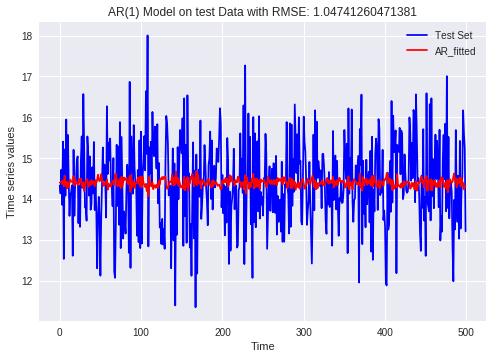

RMSE on test Data: is 1.04741260471381


In [93]:
#Run AR model for test data
model_test = ARIMA(test, order=(p, 0, 0))
results_AR_test = model_test.fit()
residuals=compute_residuals(results_AR_test.fittedvalues, test)
rmse=compute_rmse(residuals)
plt.plot(test, color='blue', label='Test Set')
plt.plot(results_AR_test.fittedvalues, color='red', label="AR_fitted")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Time series values")
plt.title('AR({}) Model on test Data with RMSE: {}'.format(p,rmse))
plt.show()
print("RMSE on test Data: is {}".format(rmse))

**Best RMSE OBTAINED FOR AUTOREGRESSION MODEL =1.047**